# Imports

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from torch.optim import Adam

import torchvision.transforms as transforms
from typing import Text, Dict
import numpy as np
from tqdm import tqdm 
import time
import json
import matplotlib.pyplot as plt
import os

# Dataset

In [50]:
def extract_dataset(batch_size: int):

  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


  # Dataset
  training_data = datasets.CIFAR10(root='data',
                                  download=True,
                                  train=True,
                                  transform=transform)

  valid_data = datasets.CIFAR10(root='data',
                              download=True,
                              train=False,
                              transform=transform)

  # Dataloader

  train_dataloader = DataLoader(dataset=training_data,
                                batch_size=batch_size,
                                shuffle=True,
                                drop_last=True)

  valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True)

  dataloader = {'train': train_dataloader,
                'valid': valid_dataloader}

  return dataloader

# Network

In [51]:
class ClassificationNetwork(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, pool_size, n_classes):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.pool_1 = nn.MaxPool2d(pool_size, pool_size)
        self.conv_2 = nn.Conv2d(out_channels, out_channels*2, kernel_size)
        self.pool_2 = nn.MaxPool2d(pool_size, pool_size)

        input_size = out_channels*2 * kernel_size * kernel_size
        self.fc1 = nn.Linear(input_size, input_size // 4)
        self.fc2 = nn.Linear(input_size // 4, input_size // 8)
        self.fc3 = nn.Linear(input_size // 8, n_classes)

    def forward(self, x):
        x = self.pool_1(F.relu(self.conv_1(x)))
        x = self.pool_2(F.relu(self.conv_2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))

        return x

# Model Class

In [52]:
class Model:

    def __init__(self,
                 name: Text,
                 network: nn.Module,
                 dataloader: Dict[Text, DataLoader],
                 loss_function,
                 seed: int,
                 save_dir: Text,
                 device = None
                 ):

        self.name = name
        self.id = time.time()
        self.network = network.to(device)
        self.dataloader = dataloader
        self.loss_function = loss_function()
        self.optimizer = None

        self.save_dir = save_dir
        self.filepath = None
        self.device = device

        self.epoch_count = []
        self.train_losses, self.valid_losses = [], []

        torch.manual_seed(seed)

    def load_optimizer(self, optimizer: Optimizer, lr: float):
        self.optimizer = optimizer(self.network.parameters(), lr=lr)

    def train(self,
              epochs: int
              ):

        for epoch in tqdm(range(epochs), desc=' > Epochs'):
            self.epoch_count.append(epoch)
            
            # Training Step
            train_loss, valid_loss = self.training_step()
            
            # Plot Losses
            plot_loss(self.train_losses, self.valid_losses)

        return

    def training_step(self):
        train_loss = self.train_one_epoch()
        valid_loss = self.validate_one_epoch()

        self.train_losses.append(train_loss)
        self.valid_losses.append(valid_loss)

        return train_loss, valid_loss

    def train_one_epoch(self):
      self.network.train()

      losses = []

      for images, labels in self.dataloader['train']:

          images = images.to(self.device)
          labels = labels.to(self.device)

          output = self.network(images)
          loss = self.loss_function(output, labels)
          losses.append(loss.item())

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

      return np.mean(losses)

    def validate_one_epoch(self):
      self.network.eval()

      losses = []

      with torch.no_grad():
          for images, labels in self.dataloader['valid']:

              images = images.to(self.device)
              labels = labels.to(self.device)

              output = self.network(images)
              loss = self.loss_function(output, labels)
              losses.append(loss.item())

          return np.mean(losses)

    def predict(self, x):
        print(f' > Input image shape: {x.shape}')
        plt.imshow(x)
        plt.show()

        x = torch.Tensor(x)
        x = x.transpose(0,2)
        x = x.transpose(1,2)
        x = x.unsqueeze(0)

        print(f'\n\n > Image shape preprocessed: {x.shape}\n')

        with torch.no_grad():
          print('--- Inference ---\n')
          output = self.network(x)
          output = output.squeeze()
          print(f' > Output shape: {output.shape}')
          print(f' > Output value: {output}\n\n')

        return output

    def save(self):
        checkpoint = {'epoch': self.epoch_count[-1],
                      'train_loss': self.train_losses[-1],
                      'valid_loss': self.valid_losses[-1],
                      'losses': {'train': self.train_losses,
                                  'valid': self.valid_losses},
                      'network_state': self.network.state_dict(),
                      'id': self.id,
                      'name': self.name,
                      'optimizer': {'name': str(self.optimizer),
                                    'state': self.optimizer.state_dict()},
                      'loss': str(self.loss_function)}

        folder_save = f'{self.save_dir}{self.name}|{self.id}/'
        ensure_folder(folder_save)

        filename = f'{self.name}|{self.id}.pth'
        model_path = f'{folder_save}{filename}'
        torch.save(checkpoint, model_path)

    @staticmethod
    def load(model_path, model_name, network, loss_function, seed, save_dir, learning_rate, dataloader):
      checkpoint = torch.load(model_path)
      
      loaded_model = Model(name=model_name,
                            network=network, 
                            loss_function=loss_function,
                            dataloader=dataloader,
                            seed=seed,
                            save_dir=save_dir)

      # Load state dicts
      loaded_model.load_optimizer(optimizer=Adam, lr=LEARNING_RATE)
      loaded_model.network.load_state_dict(checkpoint['network_state'])
      loaded_model.optimizer.load_state_dict(checkpoint['optimizer']['state'])

      return loaded_model


def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        return True

    return False

def plot_loss(train_losses, valid_losses):
  plt.plot(train_losses, c='r', label='Training Loss')
  plt.plot(valid_losses, c='b', label='Validation Loss')

  plt.legend()
  plt.show()

# Hyperparameters

In [53]:
# Dataset
N_CLASSES = 10
BATCH_SIZE = 128

# Network
IN_CHANNELS = 3
OUT_CHANNELS = 4
KERNEL_SIZE = 5
POOL_SIZE = 2

# Training
LEARNING_RATE = 0.01
EPOCHS = 10

# Others
seed = 2022
model_name = 'CIFAR10 Classification Model'
save_dir = './'


# Training Pipeline

Files already downloaded and verified
Files already downloaded and verified


 > Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


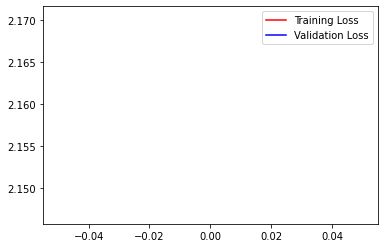

 > Epochs:  10%|█         | 1/10 [00:24<03:39, 24.39s/it]

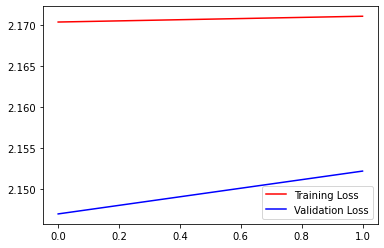

 > Epochs:  20%|██        | 2/10 [00:51<03:29, 26.19s/it]

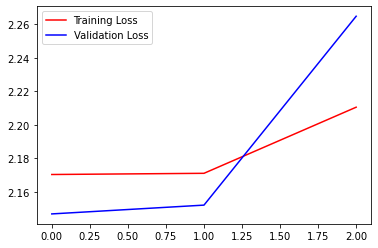

 > Epochs:  30%|███       | 3/10 [01:19<03:09, 27.02s/it]

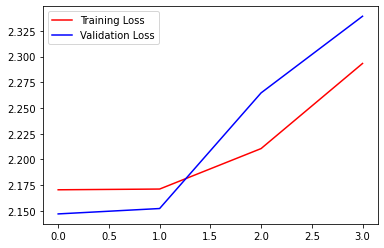

 > Epochs:  40%|████      | 4/10 [01:44<02:37, 26.20s/it]

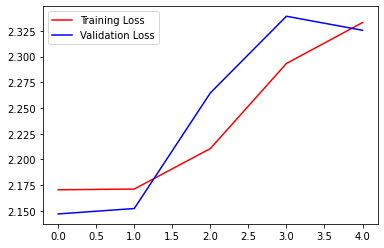

 > Epochs:  50%|█████     | 5/10 [02:09<02:07, 25.58s/it]

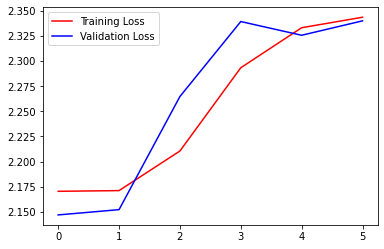

 > Epochs:  60%|██████    | 6/10 [02:37<01:44, 26.19s/it]


KeyboardInterrupt: ignored

In [54]:
# Dataset
dataloader = extract_dataset(BATCH_SIZE)

# Network
network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES)

# Loss Function
loss_function = nn.CrossEntropyLoss

# Model class
nn_model = Model(name = model_name,
                 network = network,
                 dataloader = dataloader,
                 loss_function = loss_function,
                 seed = seed,
                 save_dir = save_dir,
                 )

nn_model.load_optimizer(optimizer=Adam, lr=LEARNING_RATE)

# Training
nn_model.train(EPOCHS)

# Inference

 > Input image shape: (32, 32, 3)


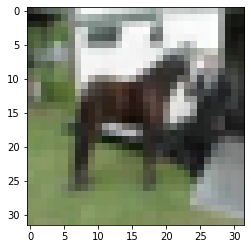



 > Image shape preprocessed: torch.Size([1, 3, 32, 32])

--- Inference ---

 > Output shape: torch.Size([10])
 > Output value: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


 > Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
 > Class Index: 0


 > Class Name predicted: airplane





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [36]:
image = dataloader['valid'].dataset.data[20]

output = nn_model.predict(image)
output = output.numpy()

class_index = np.where(output==np.max(output))[0].item()
class_name = dataloader['valid'].dataset.classes[class_index]

print(f' > Classes: {dataloader["valid"].dataset.classes}')
print(f' > Class Index: {class_index}\n\n')

print(f' > Class Name predicted: {class_name}\n\n\n')

# Save & Load Model

In [37]:
# Checkpoint save
nn_model.save()

In [38]:
checkpoint_path = '/content/CIFAR10 Classification Model|1650205279.5508654/CIFAR10 Classification Model|1650205279.5508654.pth'

In [48]:
loaded_ckpt = torch.load(checkpoint_path)

loaded_ckpt.keys()

dict_keys(['epoch', 'train_loss', 'valid_loss', 'losses', 'network_state', 'id', 'name', 'optimizer', 'loss'])

In [45]:
network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES)

loaded_model = Model.load(checkpoint_path, model_name, network, loss_function, seed, save_dir, LEARNING_RATE, dataloader)

 > Input image shape: (32, 32, 3)


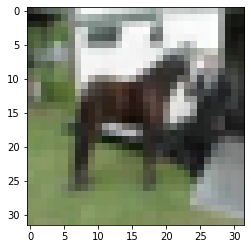



 > Image shape preprocessed: torch.Size([1, 3, 32, 32])

--- Inference ---

 > Output shape: torch.Size([10])
 > Output value: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


 > Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
 > Class Index: 0


 > Class Name predicted: airplane





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [47]:
image = dataloader['valid'].dataset.data[20]

output = loaded_model.predict(image)
output = output.numpy()

class_index = np.where(output==np.max(output))[0].item()
class_name = dataloader['valid'].dataset.classes[class_index]

print(f' > Classes: {dataloader["valid"].dataset.classes}')
print(f' > Class Index: {class_index}\n\n')

print(f' > Class Name predicted: {class_name}\n\n\n')